In [1]:
import numpy as np
import torch

text_embeddings = torch.load('embeddings/text_embedding.pth',map_location=torch.device('cpu'),weights_only=False).numpy()
test_embeddings = torch.load('embeddings/test_embeddings.pth',weights_only=False).numpy()
test_labels = torch.load('embeddings/test_labels.pth',weights_only=False).numpy()
train_embeddings = torch.load('embeddings/train_embeddings.pth',weights_only=False).numpy()
train_labels = torch.load('embeddings/train_labels.pth',weights_only=False).numpy()

def cosine_dist(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

def knn(input_database, query, k, distance_metric):
    if distance_metric == 'cosine':
        # find k nearest neighbors
        distances = np.array([cosine_dist(query, db) for db in input_database])
        indices = np.argsort(distances)[:k]
        return indices
    elif distance_metric == 'euclidean':
        distances = np.array([euclidean_dist(query, db) for db in input_database])
        indices = np.argsort(distances)[:k]
        return indices
    else:
        raise ValueError('Invalid distance metric')

# classify each test embedding using train embeddings and labels
kays = [1, 5, 10]
for k in kays:
    classifications_test = []
    for image in test_embeddings:
        indices = knn(train_embeddings, image, k, 'cosine')
        labels_of_neigbours = np.zeros(10)  # cifar10 has 10 classes
        for i in indices:
            labels_of_neigbours[train_labels[i]] += 1
        majority_class = np.argmax(labels_of_neigbours)
        classifications_test.append(majority_class)
    
    # calculate accuracy
    correct = 0
    for predict, actual in zip(classifications_test, test_labels):
        if predict == actual:
            correct += 1
    accuracy = correct / len(test_labels)
    print(f'Accuracy for cosine dist for k={k}: {accuracy}')

#     # now for euclidean distance
    classifications_test = []
    for image in test_embeddings:
        indices = knn(train_embeddings, image, k, 'euclidean')
        labels_of_neigbours = np.zeros(10)  # cifar10 has 10 classes
        for i in indices:
            labels_of_neigbours[train_labels[i]] += 1
        majority_class = np.argmax(labels_of_neigbours)
        classifications_test.append(majority_class)

#     # calculate accuracy
    correct = 0
    for predict, actual in zip(classifications_test, test_labels):
        if predict == actual:
            correct += 1
    accuracy = correct / len(test_labels)
    print(f'Accuracy for euclidean dist for k={k}: {accuracy}')

#use text_embeddings to classify test images
correct = 0
for ind,image in enumerate(test_embeddings):
    indices = knn(text_embeddings, image, 1, 'cosine')
    if indices[0] == test_labels[ind]:
        correct += 1
accuracy = correct / len(test_labels)
print(f'Accuracy for text_embeddings with cosine distance: {accuracy}')

correct = 0
for ind,image in enumerate(test_embeddings):
    indices = knn(text_embeddings, image, 1, 'euclidean')
    if indices[0] == test_labels[ind]:
        correct += 1
accuracy = correct / len(test_labels)
print(f'Accuracy for text_embeddings with euclidean distance: {accuracy}')

#mean repicrocal rank
reciprocal_rank = 0
for idx,cls in enumerate(text_embeddings):
    indices = knn(train_embeddings, cls, 100,'euclidean')
    for ind, i in enumerate(indices):
        if train_labels[i] == idx:
            reciprocal_rank += 1/(ind+1)
            break
reciprocal_rank /= len(text_embeddings)
print(f'Mean reciprocal rank for text_embeddings with euclidean distance: {reciprocal_rank}')

#precision @100
for idx,cls in enumerate(text_embeddings):
    indices = knn(train_embeddings, cls, 100, 'euclidean')
    correct = 0
    for i in indices:
        if train_labels[i] == idx:
            correct += 1
    precision = correct / 100
    print(f'Precision for class {idx}: {precision}')

#hit rate
hit_rate = 0
for idx,cls in enumerate(text_embeddings):
    indices = knn(train_embeddings, cls, 100, 'euclidean')
    hit = 0
    for i in indices:
        if train_labels[i] == idx:
            hit = 1
            break
    hit_rate += hit
hit_rate /= len(text_embeddings)
print(f'Hit rate for text_embeddings with euclidean distance: {hit_rate}')
            


precision = 0
hit_rate = 0
reciprocal_rank = 0
for idx,image in enumerate(test_embeddings):
    indices = knn(train_embeddings,image,100,'euclidean')
    correct = 0
    hit = 0
    for i in indices:
        if train_labels[i] == test_labels[idx]:
            correct += 1
            hit = 1
    precision += correct / 100
    hit_rate += hit
    for ind,i in enumerate(indices):
        if train_labels[i] == test_labels[idx]:
            reciprocal_rank += 1/(ind+1)
            break

reciprocal_rank /= len(test_embeddings)
hit_rate /= len(test_embeddings)
precision /= len(test_embeddings)

print(f'mean Precision @100 for image to image retireval: {precision}')
print(f'mean Hit rate for image to image retrieval: {hit_rate}')
print(f'mean reciprocal rank for image to image retrieval: {reciprocal_rank}')



/home/akshara/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Accuracy for cosine dist for k=1: 0.9048
Accuracy for euclidean dist for k=1: 0.9048
Accuracy for cosine dist for k=5: 0.9181
Accuracy for euclidean dist for k=5: 0.9182
Accuracy for cosine dist for k=10: 0.9194
Accuracy for euclidean dist for k=10: 0.9194
Accuracy for text_embeddings with cosine distance: 0.8781
Accuracy for text_embeddings with euclidean distance: 0.8781
Mean reciprocal rank for text_embeddings with euclidean distance: 1.0
Precision for class 0: 1.0
Precision for class 1: 0.96
Precision for class 2: 1.0
Precision for class 3: 0.92
Precision for class 4: 1.0
Precision for class 5: 0.9
Precision for class 6: 0.99
Precision for class 7: 1.0
Precision for class 8: 1.0
Precision for class 9: 0.97
Hit rate for text_embeddings with euclidean distance: 1.0
mean Precision @100 for image to image retireval: 0.8410829999999664
mean Hit rate for image to image retrieval: 0.9996
mean reciprocal rank for image to image retrieval: 0.9347961513315047


/home/akshara/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


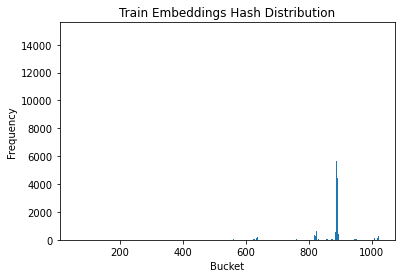

Accuracy for euclidean dist for k=5: 0.8882
Mean Reciprocal Rank with lsh: 0.9139990724149184
Mean Precision @ 100 with lsh: 0.7098769999999807
Hit Rate @ 100 with lsh: 0.9926


In [1]:
import numpy as np
import torch
from collections import Counter
from collections import defaultdict

text_embeddings = torch.load('embeddings/text_embedding.pth',map_location=torch.device('cpu'),weights_only=False).numpy()
test_embeddings = torch.load('embeddings/test_embeddings.pth',weights_only=False).numpy()
test_labels = torch.load('embeddings/test_labels.pth',weights_only=False).numpy()
train_embeddings = torch.load('embeddings/train_embeddings.pth',weights_only=False).numpy()
train_labels = torch.load('embeddings/train_labels.pth',weights_only=False).numpy()

# number of hyperplanes
nbits = 10
d = text_embeddings.shape[1]

plane_norms = np.random.uniform(low=-1.0, high=1.0, size=(nbits, d))

def hash_vector(embeddings, plane_norms):
    hashes = np.array([np.zeros(nbits) for _ in range(embeddings.shape[0])])
    for i, embedding in enumerate(embeddings):
        for j, plane_norm in enumerate(plane_norms):
            hashes[i][j] = (np.dot(embedding, plane_norm) >= 0).astype(int)
    return hashes

train_hashes = hash_vector(train_embeddings, plane_norms)
# test_hashes = hash_vector(test_embeddings, plane_norms)
# print(train_hashes)
# Plot histograms showing frequency of samples in each bucket.
import matplotlib.pyplot as plt

def binary_to_int(hashes):
    return [int(''.join(map(str,map(int,hash))), 2) for hash in hashes]

def plot_histogram(hashes, title):
    int_hashes = binary_to_int(hashes)
    c = Counter(int_hashes)
    # print(c)
    plt.bar(c.keys(), c.values())
    plt.title(title)
    plt.xlabel('Bucket')
    plt.ylabel('Frequency')
    plt.show()


plot_histogram(train_hashes, 'Train Embeddings Hash Distribution')
# plot_histogram(test_hashes, 'Test Embeddings Hash Distribution')

def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

im_hashmap = defaultdict(list)
for idx,im_hash in enumerate(train_hashes):
    im_hashmap[tuple(im_hash)].append(idx)

def ann(input_embeddings,query,query_hash,k):
    # distance metric is euclidean
    query_hash = query_hash.copy()
    query_hash = tuple(query_hash)

    num_neigh = min(k,len(im_hashmap[query_hash]))
    distances = []
    for idx in im_hashmap[query_hash]:
        dist = euclidean_dist(query,input_embeddings[idx])
        distances.append(dist)
    indices = np.argsort(distances)[:num_neigh]

    return [im_hashmap[query_hash][i] for i in indices]

k=5
classifications_test = []
for image in test_embeddings:
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,k)
    labels_of_neigbours = np.zeros(10)  # cifar10 has 10 classes
    for i in indices:
        labels_of_neigbours[train_labels[i]] += 1
    majority_class = np.argmax(labels_of_neigbours)
    classifications_test.append(majority_class)

# calculate accuracy
correct = 0
for predict, actual in zip(classifications_test, test_labels):
    if predict == actual:
        correct += 1
accuracy = correct / len(test_labels)
print(f'Accuracy for euclidean dist for k={k}: {accuracy}')

# mean reciprocla rank for 100 nearest neighbors # doubt
mrr = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            mrr += 1/(id+1)
            break

mrr /= len(test_labels)
print(f'Mean Reciprocal Rank with lsh: {mrr}')

# mean precision@100
precision = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    correct = 0
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            correct += 1
    precision += correct/100

precision /= len(test_labels)
print(f'Mean Precision @ 100 with lsh: {precision}')

# hit rate @ 100
hit_rate = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    hit = 0
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            hit = 1
            break
    hit_rate += hit

hit_rate /= len(test_labels)
print(f'Hit Rate @ 100 with lsh: {hit_rate}')

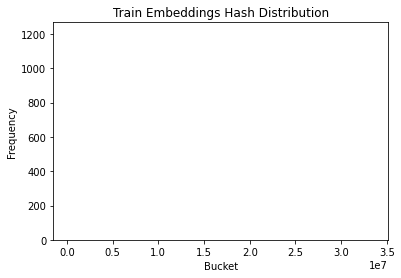

Accuracy for euclidean dist for k=5: 0.6713
Mean Reciprocal Rank with lsh: 0.7300272307573475
Mean Precision @ 100 with lsh: 0.1873679999999934
Hit Rate @ 100 with lsh: 0.8117


In [2]:
import numpy as np
import torch
from collections import Counter
from collections import defaultdict

text_embeddings = torch.load('embeddings/text_embedding.pth',map_location=torch.device('cpu'),weights_only=False).numpy()
test_embeddings = torch.load('embeddings/test_embeddings.pth',weights_only=False).numpy()
test_labels = torch.load('embeddings/test_labels.pth',weights_only=False).numpy()
train_embeddings = torch.load('embeddings/train_embeddings.pth',weights_only=False).numpy()
train_labels = torch.load('embeddings/train_labels.pth',weights_only=False).numpy()

# number of hyperplanes
nbits = 25
d = text_embeddings.shape[1]

plane_norms = np.random.uniform(low=-1.0, high=1.0, size=(nbits, d))

def hash_vector(embeddings, plane_norms):
    hashes = np.array([np.zeros(nbits) for _ in range(embeddings.shape[0])])
    for i, embedding in enumerate(embeddings):
        for j, plane_norm in enumerate(plane_norms):
            hashes[i][j] = (np.dot(embedding, plane_norm) >= 0).astype(int)
    return hashes

train_hashes = hash_vector(train_embeddings, plane_norms)
# test_hashes = hash_vector(test_embeddings, plane_norms)
# print(train_hashes)
# Plot histograms showing frequency of samples in each bucket.
import matplotlib.pyplot as plt

def binary_to_int(hashes):
    return [int(''.join(map(str,map(int,hash))), 2) for hash in hashes]

def plot_histogram(hashes, title):
    int_hashes = binary_to_int(hashes)
    c = Counter(int_hashes)
    # print(c)
    plt.bar(c.keys(), c.values())
    plt.title(title)
    plt.xlabel('Bucket')
    plt.ylabel('Frequency')
    plt.show()


plot_histogram(train_hashes, 'Train Embeddings Hash Distribution')
# plot_histogram(test_hashes, 'Test Embeddings Hash Distribution')

def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

im_hashmap = defaultdict(list)
for idx,im_hash in enumerate(train_hashes):
    im_hashmap[tuple(im_hash)].append(idx)

def ann(input_embeddings,query,query_hash,k):
    # distance metric is euclidean
    query_hash = query_hash.copy()
    query_hash = tuple(query_hash)

    num_neigh = min(k,len(im_hashmap[query_hash]))
    distances = []
    for idx in im_hashmap[query_hash]:
        dist = euclidean_dist(query,input_embeddings[idx])
        distances.append(dist)
    indices = np.argsort(distances)[:num_neigh]

    return [im_hashmap[query_hash][i] for i in indices]

k=5
classifications_test = []
for image in test_embeddings:
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,k)
    labels_of_neigbours = np.zeros(10)  # cifar10 has 10 classes
    for i in indices:
        labels_of_neigbours[train_labels[i]] += 1
    majority_class = np.argmax(labels_of_neigbours)
    classifications_test.append(majority_class)

# calculate accuracy
correct = 0
for predict, actual in zip(classifications_test, test_labels):
    if predict == actual:
        correct += 1
accuracy = correct / len(test_labels)
print(f'Accuracy for euclidean dist for k={k}: {accuracy}')

# mean reciprocla rank for 100 nearest neighbors # doubt
mrr = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            mrr += 1/(id+1)
            break

mrr /= len(test_labels)
print(f'Mean Reciprocal Rank with lsh: {mrr}')

# mean precision@100
precision = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    correct = 0
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            correct += 1
    precision += correct/100

precision /= len(test_labels)
print(f'Mean Precision @ 100 with lsh: {precision}')

# hit rate @ 100
hit_rate = 0
for i,image in enumerate(test_embeddings):
    query = image
    query_hash = hash_vector(np.array([query]), plane_norms)[0]
    indices = ann(train_embeddings,query,query_hash,100)
    hit = 0
    for id,index in enumerate(indices):
        if train_labels[index] == test_labels[i]:
            hit = 1
            break
    hit_rate += hit

hit_rate /= len(test_labels)
print(f'Hit Rate @ 100 with lsh: {hit_rate}')

/home/akshara/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


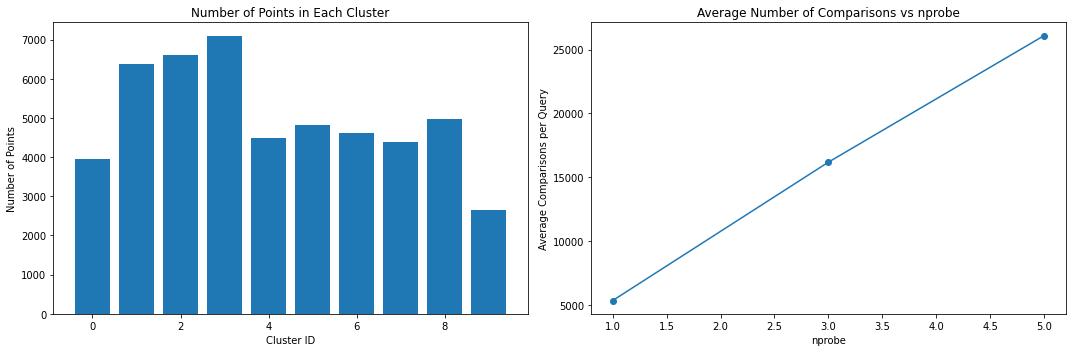


Retrieval Metrics:
nprobe | MRR | Precision@100 | Hit Rate@100
---------------------------------------------
     1 | 0.927 | 0.835 | 0.999
     3 | 0.934 | 0.842 | 0.999
     5 | 0.935 | 0.841 | 1.000


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def calculate_metrics(query_results, query_labels, gallery_labels, k=100):
    """Calculate MRR, precision@k, and hit_rate@k."""
    mrr_sum = 0
    precision_sum = 0
    hit_count = 0
    
    for i, (results, query_label) in enumerate(zip(query_results, query_labels)):
        # Calculate reciprocal rank
        relevant_positions = np.where(gallery_labels[results] == query_label)[0]
        if len(relevant_positions) > 0:
            mrr_sum += 1.0 / (relevant_positions[0] + 1)
            
        # Calculate precision@k
        top_k_results = results[:k]
        relevant_in_k = np.sum(gallery_labels[top_k_results] == query_label)
        precision_sum += relevant_in_k / k
        
        # Calculate hit_rate@k
        if relevant_in_k > 0:
            hit_count += 1
    
    n_queries = len(query_labels)
    mrr = mrr_sum / n_queries
    precision_at_k = precision_sum / n_queries
    hit_rate = hit_count / n_queries
    
    return mrr, precision_at_k, hit_rate

def search_with_nprobe(query_embedding, cluster_centers, cluster_to_data, train_embeddings, nprobe):
    """Search for similar images using specified nprobe value."""
    # Find distances to all cluster centers
    distances = np.linalg.norm(cluster_centers - query_embedding, axis=1)
    closest_clusters_idx = np.argsort(distances)[:nprobe]
    
    # Collect candidates from top nprobe clusters
    candidates = []
    for cluster_idx in closest_clusters_idx:
        candidates.extend(cluster_to_data[cluster_idx])
    
    # Calculate distances to all candidates
    candidate_embeddings = train_embeddings[candidates]
    distances = np.linalg.norm(candidate_embeddings - query_embedding, axis=1)
    
    # Sort candidates by distance
    sorted_indices = np.argsort(distances)
    sorted_candidates = np.array(candidates)[sorted_indices]
    
    return sorted_candidates, len(candidates)

# Load data
test_embeddings = torch.load('embeddings/test_embeddings.pth', weights_only=False).numpy()
test_labels = torch.load('embeddings/test_labels.pth', weights_only=False).numpy()
train_embeddings = torch.load('embeddings/train_embeddings.pth', weights_only=False).numpy()
train_labels = torch.load('embeddings/train_labels.pth', weights_only=False).numpy()

n_clusters = 10

# Clustering using KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(train_embeddings)
cluster_centers = kmeans.cluster_centers_

# Assign train embeddings to their closest cluster
train_clusters = kmeans.predict(train_embeddings)

# Create the inverted file index
cluster_to_data = defaultdict(list)
for idx, cluster_id in enumerate(train_clusters):
    cluster_to_data[cluster_id].append(idx)

# Evaluate different nprobe values
nprobe_values = [1, 3, 5]
metrics_results = []
avg_comparisons = []

for nprobe in nprobe_values:
    all_results = []
    total_comparisons = 0
    
    for query_embedding in test_embeddings:
        results, n_comparisons = search_with_nprobe(
            query_embedding, 
            cluster_centers, 
            cluster_to_data, 
            train_embeddings, 
            nprobe
        )
        all_results.append(results)
        total_comparisons += n_comparisons
    
    # Calculate metrics
    mrr, precision_at_k, hit_rate = calculate_metrics(all_results, test_labels, train_labels)
    metrics_results.append((mrr, precision_at_k, hit_rate))
    avg_comparisons.append(total_comparisons / len(test_embeddings))

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Number of points in each cluster
plt.subplot(1, 2, 1)
cluster_sizes = [len(cluster_to_data[i]) for i in range(n_clusters)]
plt.bar(range(n_clusters), cluster_sizes)
plt.title('Number of Points in Each Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Points')

# Plot 2: Average comparisons vs nprobe
plt.subplot(1, 2, 2)
plt.plot(nprobe_values, avg_comparisons, marker='o')
plt.title('Average Number of Comparisons vs nprobe')
plt.xlabel('nprobe')
plt.ylabel('Average Comparisons per Query')

plt.tight_layout()
plt.show()

# Print metrics
print("\nRetrieval Metrics:")
print("nprobe | MRR | Precision@100 | Hit Rate@100")
print("-" * 45)
for nprobe, (mrr, precision, hit_rate) in zip(nprobe_values, metrics_results):
    print(f"{nprobe:6d} | {mrr:.3f} | {precision:.3f} | {hit_rate:.3f}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/akshara/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


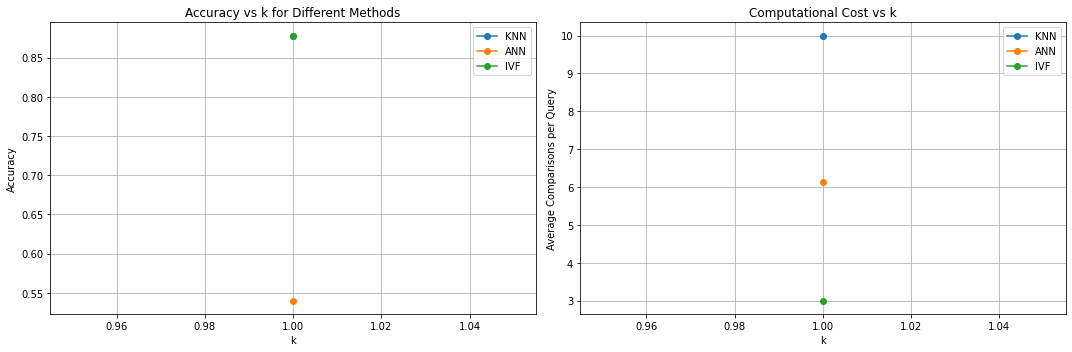


Summary Statistics:

Accuracy at k=1:
KNN: 0.8781
ANN: 0.5401
IVF: 0.8781

Average comparisons at k=1:
KNN: 10.0
ANN: 6.1
IVF: 3.0


In [18]:
import numpy as np
import torch
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

# Load data
text_embeddings = torch.load('embeddings/text_embedding.pth', map_location=torch.device('cpu'), weights_only=False).numpy()
test_embeddings = torch.load('embeddings/test_embeddings.pth', weights_only=False).numpy()
test_labels = torch.load('embeddings/test_labels.pth', weights_only=False).numpy()

# Distance metrics
def cosine_dist(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2)**2))

# KNN implementation
def knn(input_database, query, k, distance_metric):
    comparisons = 0
    if distance_metric == 'cosine':
        distances = np.array([cosine_dist(query, db) for db in input_database])
        comparisons = len(input_database)
    elif distance_metric == 'euclidean':
        distances = np.array([euclidean_dist(query, db) for db in input_database])
        comparisons = len(input_database)
    else:
        raise ValueError('Invalid distance metric')
    indices = np.argsort(distances)[:k]
    return indices, comparisons

# ANN implementation
nbits = 1
d = text_embeddings.shape[1]
plane_norms = np.random.uniform(low=-1.0, high=1.0, size=(nbits, d))

def hash_vector(embeddings, plane_norms):
    hashes = np.array([np.zeros(nbits) for _ in range(embeddings.shape[0])])
    for i, embedding in enumerate(embeddings):
        for j, plane_norm in enumerate(plane_norms):
            hashes[i][j] = (np.dot(embedding, plane_norm) >= 0).astype(int)
    return hashes

text_hashes = hash_vector(text_embeddings, plane_norms)

im_hashmap = defaultdict(list)
for idx, im_hash in enumerate(text_hashes):
    im_hashmap[tuple(im_hash)].append(idx)

def ann(input_embeddings, query, query_hash, k):
    query_hash = tuple(query_hash.copy())
    bucket = im_hashmap[query_hash]
    comparisons = len(bucket)
    
    if len(bucket) == 0:
        return [], comparisons
    
    distances = []
    for idx in bucket:
        dist = euclidean_dist(query, input_embeddings[idx])
        distances.append(dist)
    
    num_neigh = min(k, len(bucket))
    indices = np.argsort(distances)[:num_neigh]
    return [bucket[i] for i in indices], comparisons

# IVF implementation
def ivf_search(query, cluster_centers, cluster_to_data, input_embeddings, k, nprobe=3):
    # Find distances to all cluster centers
    distances = np.array([euclidean_dist(query, center) for center in cluster_centers])
    closest_clusters = np.argsort(distances)[:nprobe]
    
    # Collect candidates from top nprobe clusters
    candidates = []
    for cluster_idx in closest_clusters:
        candidates.extend(cluster_to_data[cluster_idx])
    
    # Calculate distances to candidates
    distances = []
    for idx in candidates:
        dist = euclidean_dist(query, input_embeddings[idx])
        distances.append(dist)
    
    # Sort and return top k
    sorted_indices = np.argsort(distances)[:k]
    return [candidates[i] for i in sorted_indices], len(candidates)

# Prepare IVF index
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(text_embeddings)
cluster_centers = kmeans.cluster_centers_
text_clusters = kmeans.predict(text_embeddings)

cluster_to_data = defaultdict(list)
for idx, cluster_id in enumerate(text_clusters):
    cluster_to_data[cluster_id].append(idx)

# Evaluation
k_values = [1]
methods = ['KNN', 'ANN', 'IVF']
accuracies = {method: [] for method in methods}
avg_comparisons = {method: [] for method in methods}

for k in tqdm(k_values):
    # KNN evaluation
    correct = 0
    total_comparisons = 0
    for ind, image in enumerate(test_embeddings):
        indices, comps = knn(text_embeddings, image, k, 'euclidean')
        if test_labels[ind] in indices:
            correct += 1
        total_comparisons += comps
    accuracies['KNN'].append(correct / len(test_labels))
    avg_comparisons['KNN'].append(total_comparisons / len(test_labels))
    
    # ANN evaluation
    correct = 0
    total_comparisons = 0
    for ind, image in enumerate(test_embeddings):
        query_hash = hash_vector(np.array([image]), plane_norms)[0]
        indices, comps = ann(text_embeddings, image, query_hash, k)
        if len(indices) > 0 and test_labels[ind] in indices:
            correct += 1
        total_comparisons += comps
    accuracies['ANN'].append(correct / len(test_labels))
    avg_comparisons['ANN'].append(total_comparisons / len(test_labels))
    
    # IVF evaluation
    correct = 0
    total_comparisons = 0
    for ind, image in enumerate(test_embeddings):
        indices, comps = ivf_search(image, cluster_centers, cluster_to_data, text_embeddings, k)
        if test_labels[ind] in indices:
            correct += 1
        total_comparisons += comps
    accuracies['IVF'].append(correct / len(test_labels))
    avg_comparisons['IVF'].append(total_comparisons / len(test_labels))

# Plotting
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(k_values, accuracies[method], marker='o', label=method)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for Different Methods')
plt.legend()
plt.grid(True)

# Average comparisons comparison
plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(k_values, avg_comparisons[method], marker='o', label=method)
plt.xlabel('k')
plt.ylabel('Average Comparisons per Query')
plt.title('Computational Cost vs k')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nAccuracy at k=1:")
for method in methods:
    print(f"{method}: {accuracies[method][0]:.4f}")

print("\nAverage comparisons at k=1:")
for method in methods:
    print(f"{method}: {avg_comparisons[method][0]:.1f}")